In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

2024-04-12 11:55:14.000245: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-12 11:55:14.017203: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 11:55:14.121883: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 11:55:14.121924: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 11:55:14.121948: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Why we see two 'branches' while comparing t_opt with t_pred? 

Here I repeated the task for two centered 2D normal distribuitons, so that the problem was easier to analyze.

## Task 1

### a)

In [2]:
def KL_mult_normal(mu1, mu2, Sigma1, Sigma2):
    return (np.dot(mu2-mu1, np.dot(np.linalg.inv(Sigma2), mu2 - mu1)) + np.sum(np.diag(np.dot(np.linalg.inv(Sigma2), Sigma1))) \
        - np.log(np.linalg.det(Sigma1)/np.linalg.det(Sigma2)) - mu1.shape[0])/2

In [3]:
def T_opt(x, mu1, mu2, Sigma1, Sigma2):
    res = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        ft = -np.log(np.linalg.det(Sigma1))/2 - np.dot(np.dot(np.linalg.inv(Sigma1), (x[i,:] - mu1)), x[i,:] - mu1)/2 
        st = np.log(np.linalg.det(Sigma2))/2 + np.dot(np.dot(np.linalg.inv(Sigma2), x[i,:] - mu2), x[i,:] - mu2)/2
        res[i] = ft+st
    return res

### b)

2d cause then we can draw it

In [4]:
np.random.seed(1234)
n = 10000
mu1 = np.array([0, 0])
mu2 = np.array([0, 0])
Sigma1 = np.array([[1, 0.5], [0.5, 1]])
Sigma2 = np.array([[1, -0.5], [-0.5, 1]])
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
x = np.concatenate((x1, x2), axis=0)
y = np.concatenate((1.0*np.ones(n), 0.0*np.zeros(n)))

In [5]:
def DV_fun(y, t):
    n1 = np.sum(y)
    n2 = np.sum(1 - y)
    return np.sum(t*y)/n1 - np.log(np.sum(np.exp(t)*(1-y))/n2)

In [6]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2)

0.6666666666666665

In [7]:
DV_fun(y, T_opt(x, mu1, mu2, Sigma1, Sigma2))

0.6688109449953747

### c)

In [8]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
    return -(first_term - second_term) 

### d)

In [9]:
keras.utils.set_random_seed(12)

model_inputs = keras.Input(shape=(2))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=DV_loss)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [11]:
hist = model.fit(x_train, y_train, epochs=250, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/250
15/15 [==============================] - 1s 22ms/step - loss: 0.0429 - val_loss: 0.0281
Epoch 2/250
15/15 [==============================] - 0s 7ms/step - loss: 0.0208 - val_loss: 0.0124
Epoch 3/250
15/15 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0038
Epoch 4/250
15/15 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: -0.0016
Epoch 5/250
15/15 [==============================] - 0s 6ms/step - loss: -0.0025 - val_loss: -0.0059
Epoch 6/250
15/15 [==============================] - 0s 6ms/step - loss: -0.0063 - val_loss: -0.0091
Epoch 7/250
15/15 [==============================] - 0s 7ms/step - loss: -0.0094 - val_loss: -0.0121
Epoch 8/250
15/15 [==============================] - 0s 6ms/step - loss: -0.0121 - val_loss: -0.0148
Epoch 9/250
15/15 [==============================] - 0s 6ms/step - loss: -0.0147 - val_loss: -0.0173
Epoch 10/250
15/15 [==============================] - 0s 6ms/step - loss: -0.0172 - val_loss: -0.

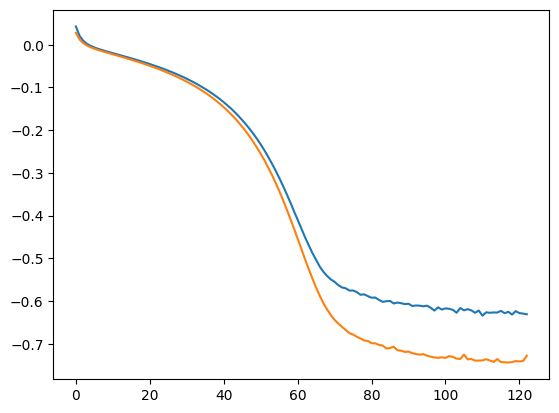

In [12]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

### e)

In [13]:
t_x_pred = model.predict(x)
t_x_pred = t_x_pred[:,0]

625/625 [==============================] - 1s 1ms/step


In [14]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

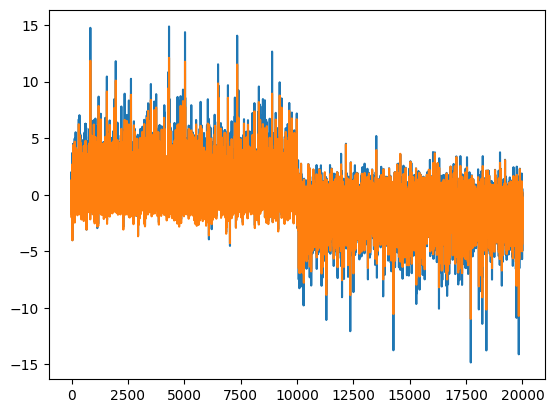

In [15]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)
plt.show()

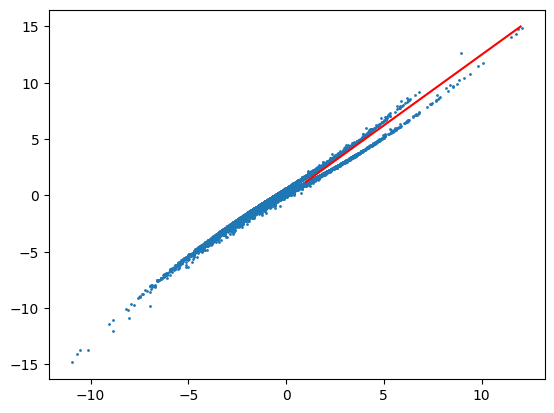

In [16]:
plt.scatter(t_x_pred, t_x_opt, s=1)
x0 = 1
x1 = 12
y0 = 1.2
y1 = 15
plt.plot([x0, x1], [y0, y1], color='red')
plt.show()

In [17]:
a = (y0 - y1)/(x0 - x1)
b =  y0 - a*x0

In [18]:
up_group_den1 = ((t_x_opt > a*t_x_pred + b) & (t_x_pred > x0))
down_group_den1 = ((t_x_opt < a*t_x_pred + b) & (t_x_pred > x0))
others_group_den1 = t_x_pred < x0
others_group_den1[n:] = False
all_den2 = np.concatenate([np.repeat(False, n), np.repeat(True, n)])

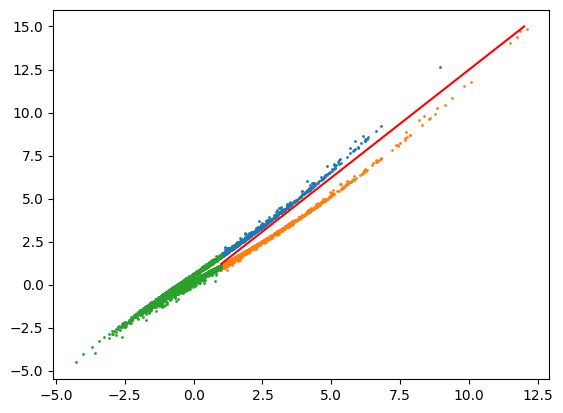

In [19]:
plt.scatter(t_x_pred[up_group_den1], t_x_opt[up_group_den1], s=1)
plt.scatter(t_x_pred[down_group_den1], t_x_opt[down_group_den1], s=1)
plt.scatter(t_x_pred[others_group_den1], t_x_opt[others_group_den1], s=1)
#plt.scatter(t_x_pred[all_den2], t_x_opt[all_den2], s=1)
plt.plot([x0, x1], [y0, y1], color='red')
plt.show()

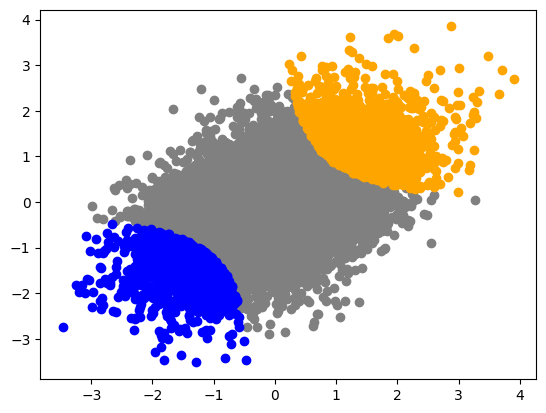

In [20]:
plt.scatter(x[others_group_den1,0],x[others_group_den1,1], color='gray')
plt.scatter(x[up_group_den1,0],x[up_group_den1,1], color='blue')
plt.scatter(x[down_group_den1,0],x[down_group_den1,1], color='orange')
plt.show()

In [21]:
import seaborn as sns

In [23]:
x_grid = np.meshgrid(np.arange(-4, 4, 0.05), np.arange(-4, 4, 0.05), indexing='ij')
x_grid = np.array([np.array(x_grid)[0].flatten(), np.array(x_grid)[1].flatten()]).T

The plot below is symmetric around $x=y$, because we the densities $p$ and $q$ are symmetric around $x=y$ and we compute the values of t_opt using the true densities. Thus, the problem is not with the formula itself. The probles is in the model, as we our input to the model consists of x and the model doesn't know about that symmetry we see, so it fits T to x from bottom left and to x from upper right corner separately (and that's because the errors here and there are not the same).

The fact that we see the problem only for large positive values might be caused by the DV representation (but that's a guess). 

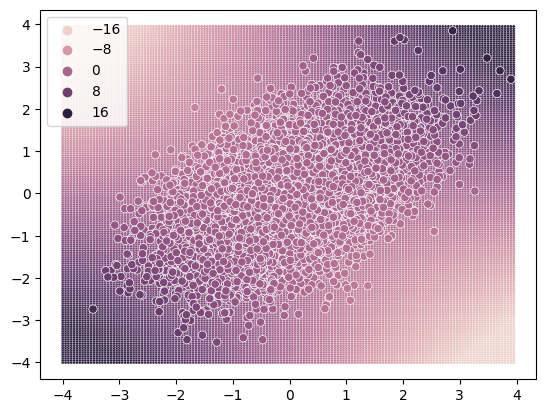

In [32]:
sns.scatterplot(x=x_grid[:,0], y=x_grid[:,1], hue=T_opt(x_grid, mu1, mu2, Sigma1, Sigma2), s=5, hue_norm=(-16, 16))
sns.scatterplot(x=x[:n,0],y=x[:n,1], hue=t_x_opt[:n], legend=False, hue_norm=(-16, 16))
# sns.scatterplot(x=x[n:,0],y=x[n:,1], hue=t_x_opt[n:], legend=False, hue_norm=(-16, 16))
plt.show()